In [2]:
from datetime import datetime
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 2.0 Exploratory Weather Data Analysis
This analysis will use daily weather data created in [part one](#).  While we are most interested in analyzing precipitation values and trends, part of this analysis will focus on both temperature and precipitation values in order to better quantify the "missingness" of the data produced by weather stations in London Ontario and to identify correlations or relationships between weather and precipitation.

## 2.1 Data Prep
The preperatory phase included transformations to create daily observational data by averaging observations from multiple sensors (weather stations).  The data prepertation here consists of:

* Loading the data
* Creating new fields that capture the year and month of the observations, making the data easier to aggregate (group)
* Creating a seasonal indicator field that captures the season in which the observation was made

In [3]:
df = pd.read_csv("../data/weather_by_day_2017_06_03.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 12 columns):
date                  2736 non-null object
maxTemp               2735 non-null float64
minTemp               2736 non-null float64
meanTemp              2735 non-null float64
heatDegDays           2735 non-null float64
coolDegDays           2735 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2697 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
spdOfMaxGustKMH       1930 non-null float64
dtypes: float64(11), object(1)
memory usage: 256.6+ KB
None


,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN


### Dates

In [4]:
df['date'] = pd.to_datetime(df['date'])

Add date components as separate columns so we can subset the data more easily

In [5]:
df.loc[:, 'year'] = df['date'].apply(lambda x: x.year)
df.loc[:, 'month'] = df['date'].apply(lambda x: x.month)
df.head()

,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH,year,month
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN,2010,1
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN,2010,1
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN,2010,1
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN,2010,1
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN,2010,1


### Seasons
Adding a seasonal indicator will allow us to visualize seasonal weather effects (if any).  Seasonal bounds for the Northern hemisphere are used to label each observation below
> ...for temperate areas in the northern hemisphere, spring begins on 1 March, summer on 1 June, autumn on 1 September, and winter on 1 December. - [Wikipedia](https://en.wikipedia.org/wiki/Season#Meteorological).

In [6]:
def season(date):
  if date.month == 12 or date.month < 3:
    # December - Feb
    return 'winter'
  elif date.month >= 3 and date.month < 6:
    # March - June
    return 'spring'
  elif date.month >= 6 and date.month < 9:
    # June - Sept
    return 'summer'
  else:
    # Sept - Nov
    return 'fall'

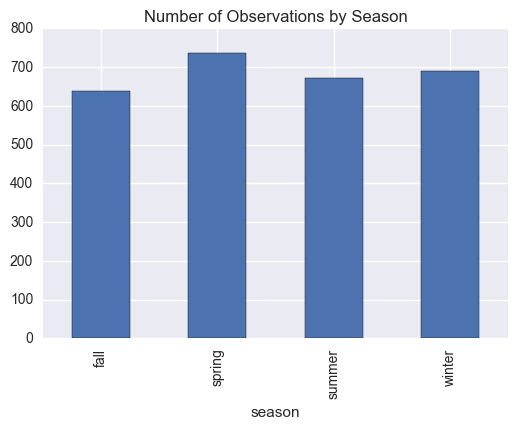

In [7]:
df['season'] = df.date.apply(season)
g = df.groupby('season').size().plot(kind='bar')
_ = g.set_title("Number of Observations by Season")

## 2.2 Missing Value Analysis

### Missing values by variable

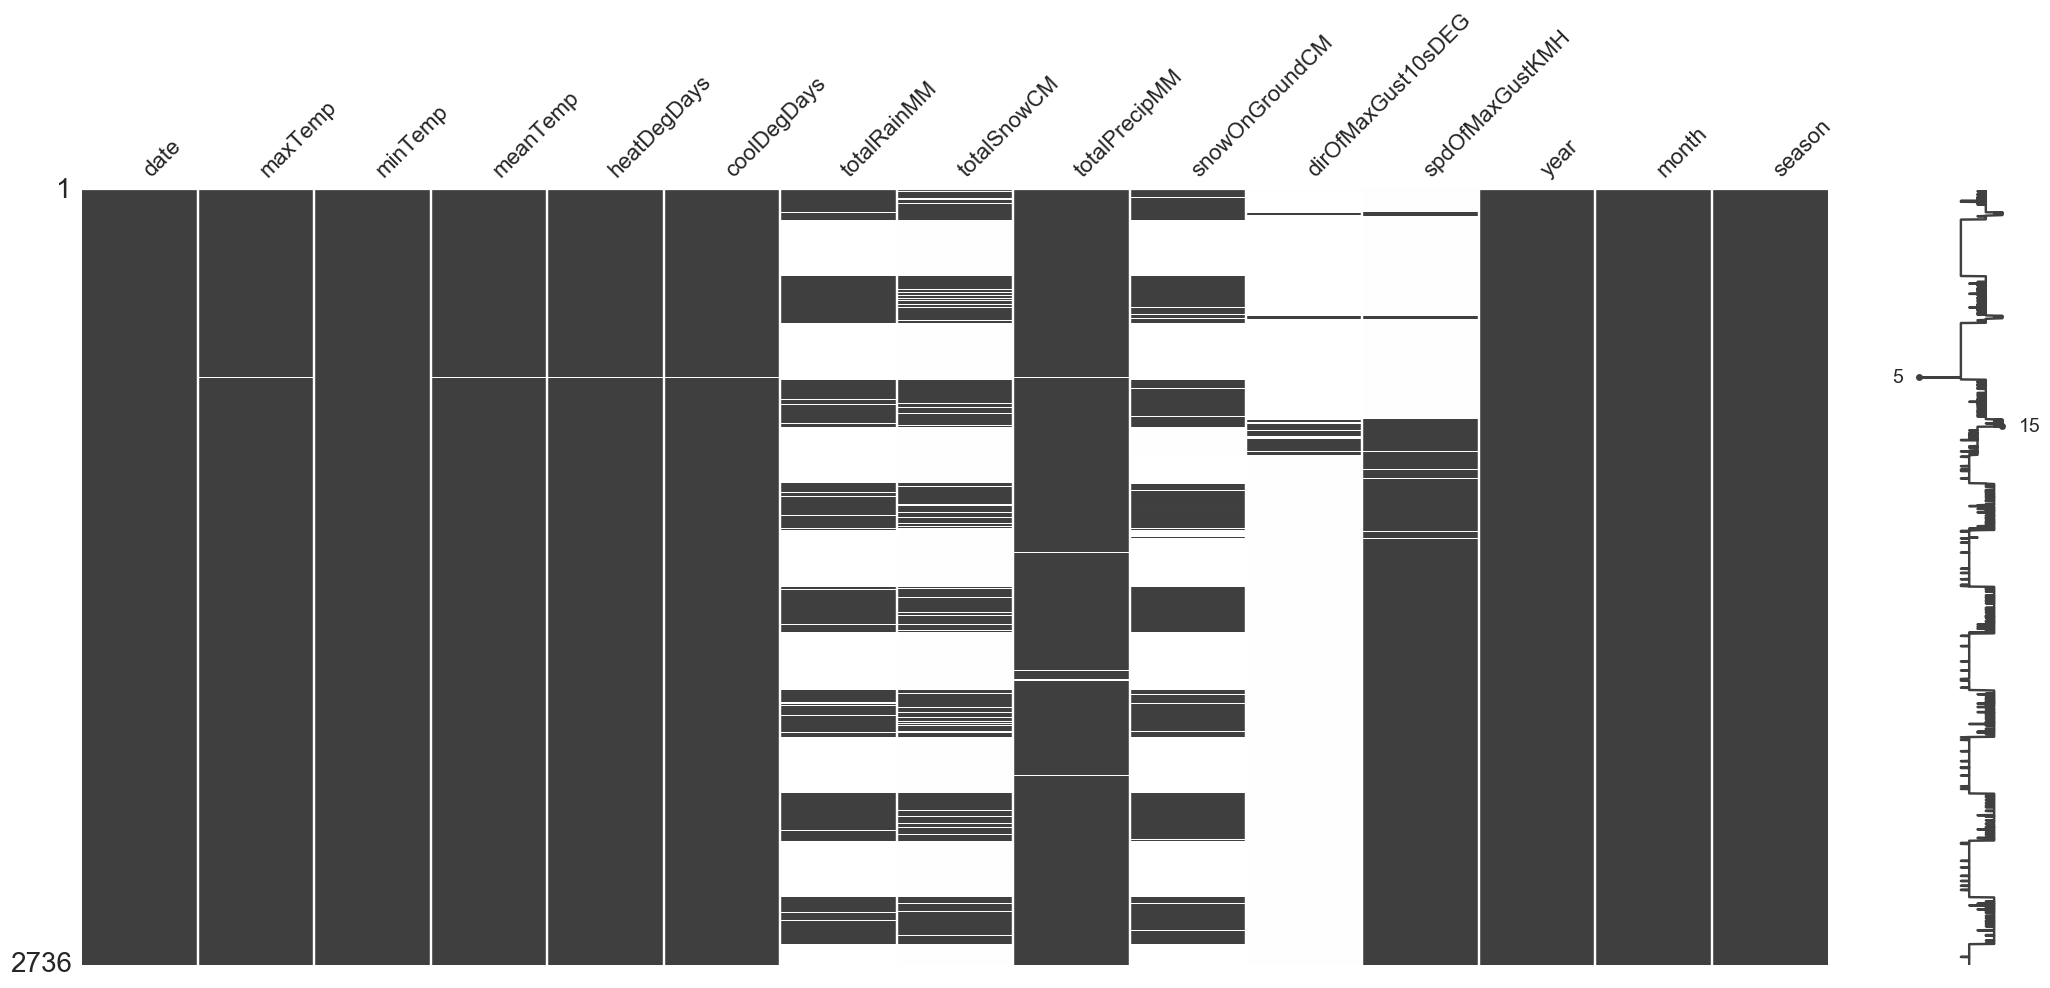

In [8]:
msno.matrix(df.sort_values('date', ascending=True))

In [9]:
df.isnull().sum(axis=1).sort_values(ascending=False).values[0]

10

In [10]:
max_missing_vars = df.isnull().sum(axis=1).sort_values(ascending=False).values[0]
max_missing_day = df.loc[df.isnull().sum(axis=1).sort_values(ascending=False).head(1).index, 'date'].values[0]
print("Number of variables: %s" % len(df.columns))
print("Highest number of missing values: %s" % max_missing_vars)
print("Highest % of missing measurements: {:.2f}".format(max_missing_vars / len(df.columns)))
print("Day with highest number of missing values: %s" % pd.to_datetime(max_missing_day).date())

Number of variables: 15
Highest number of missing values: 10
Highest % of missing measurements: 0.67
Day with highest number of missing values: 2011-10-24


Get a better understanding of the distribution of missing values

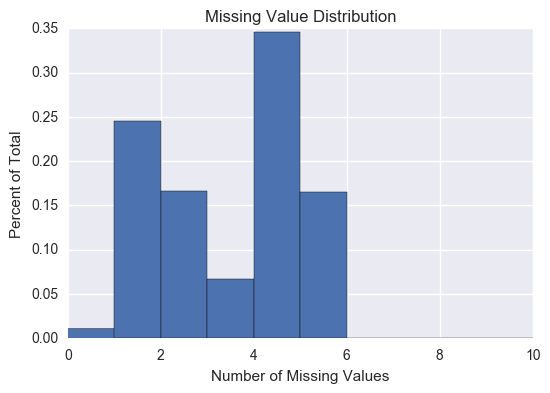

In [11]:
plt.hist(df.isnull().sum(axis=1), weights=np.zeros(len(df)) + 1. / len(df))
plt.title("Missing Value Distribution");
plt.xlabel("Number of Missing Values");
plt.ylabel("Percent of Total");

Out of 2,736 observations, the maximum number of missing values for a day is 10 (66% of the variables) which was observed on October 24, 2011.  We can safely ignore this single missing observation.

Rainfall looks to be systematically missing but other variables look okay.  Since the data is sorted by the date column in the matrix show above, it's obvious that rainfall data is missing _periodically_.  We can plot the values over time to get a better look at the missing rainfall data.

### Missing rainfall trends

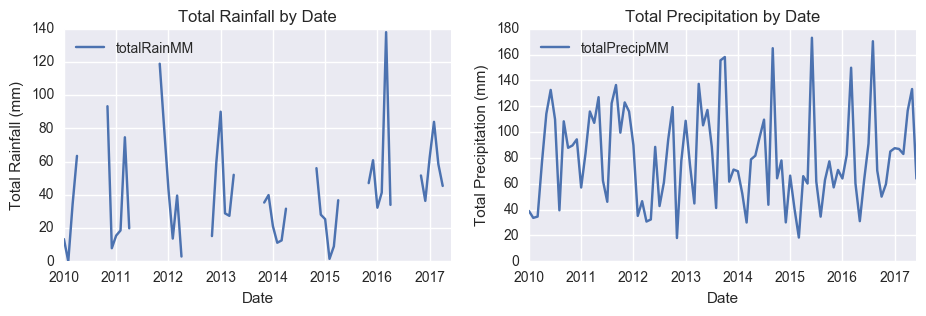

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(11,3))
# Total rainfall
df[['date', 'totalRainMM']].set_index('date').resample('1M').sum().plot(ax=ax1);
ax1.set_title("Total Rainfall by Date")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Rainfall (mm)");
# Total precipitation
df[['date', 'totalPrecipMM']].set_index('date').resample('1M').sum().plot(ax=ax2);
ax2.set_title("Total Precipitation by Date")
ax2.set_xlabel("Date")
ax2.set_ylabel("Total Precipitation (mm)");

From this graph, we can begin to see how precipitation in 2016 and 2017 has been higher, on average, in 2016 and 2017 compared to previous years.  It is also evident that there is a positive trend from 2014 - 2017.  At this point, we could attempt to interpolate missing values and perform a time series analysis to model the rainfall growth but it's out of scope for this analysis.

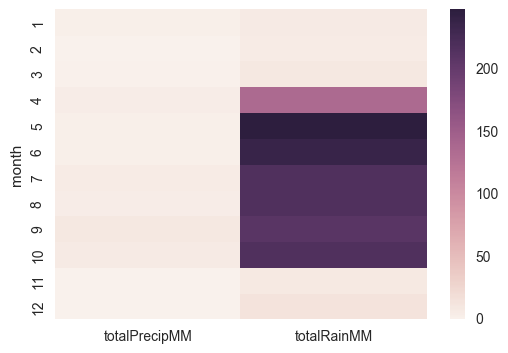

In [13]:
d = df[['month', 'totalPrecipMM', 'totalRainMM']].groupby(['month'])[['totalPrecipMM', 'totalRainMM']]
d = d.apply(lambda x: pd.isnull(x).sum())
sns.heatmap(d);

April through October is missing rain measurements year-over-year.  There are a few ways we could handle this:

1. Infer rain values using linear regression.  This may be problematic since we don't have examples of rain for a majority of the months (April through October)
2. Instead of classifying days as rain/not-rainy we could classify them as very low, low, medium, high, and very high precipitation
3.  Depending on the relationships present in the data, we may be able to model rain/no-rain as a logistic regression

## 2.3 Multivariate Data Analysis
We'll look at the distributions of each variable simultaneously to evaluate distributions and relationships.  The table below describes statistical properties of the daily weather observations and the pair plot of the continuous variables visualizes marginal and joint distributions.

In [27]:
cont_vars = [
  'month',
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
  'totalPrecipMM',
  'totalRainMM'
]
df[cont_vars].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
month,2736.0,6.323465,3.446044,1.00,3.0000,6.00,9.0000,12.0
minTemp,2736.0,3.321637,10.060675,-29.65,-3.3625,3.35,11.5625,24.6
meanTemp,2735.0,8.287916,10.682868,-23.85,0.1000,8.80,17.5750,30.7
maxTemp,2735.0,13.240420,11.593045,-18.90,3.5000,14.30,23.6250,36.7
totalPrecipMM,2697.0,2.706155,6.166819,0.00,0.0000,0.10,2.3500,69.7
totalRainMM,1208.0,1.585596,4.502499,0.00,0.0000,0.00,0.2000,39.3


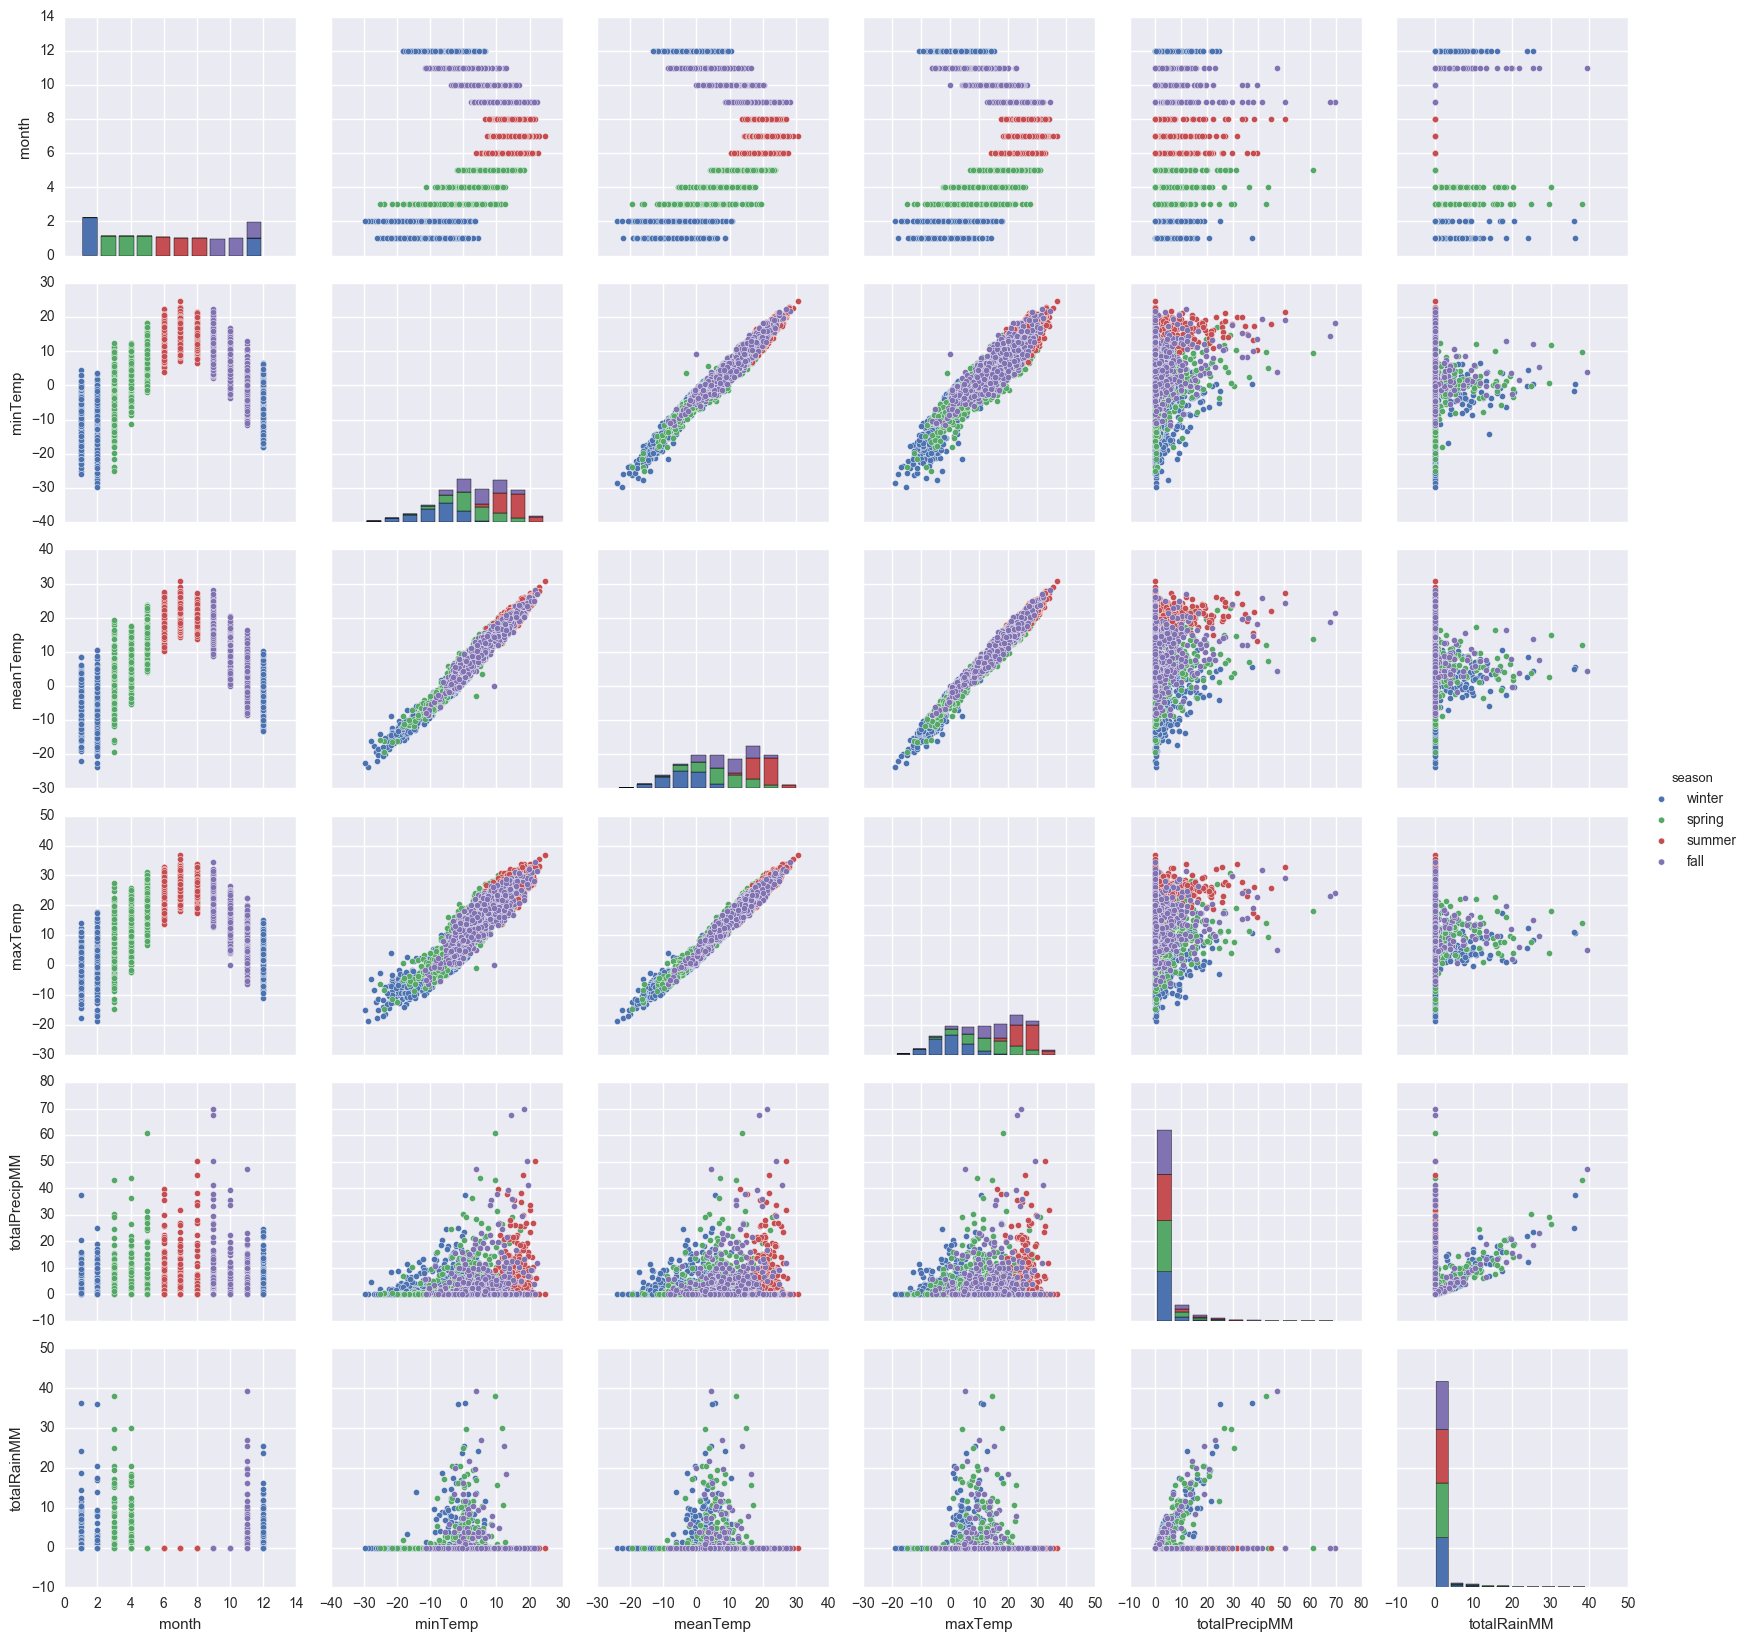

In [14]:
sns.pairplot(df[cont_vars].fillna(0), hue='season', size=2.75);

* As you would expect, temperature distributions are bimodal which account for the different seasons and are highly correlated and fall and spring share significant overlap with summer and winter temperatures while summer and winter temperatures share minimal overlap
* Precipitation appears to be positively correlated with temperature/season

### Temperature and precipitation

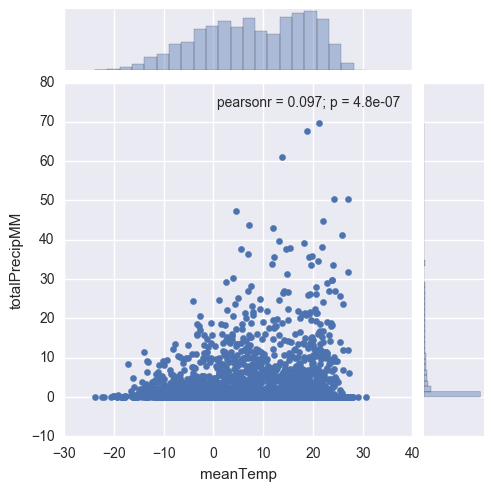

In [15]:
sns.jointplot(x="meanTemp", y="totalPrecipMM", data=df[['totalPrecipMM', 'meanTemp']], size=5);

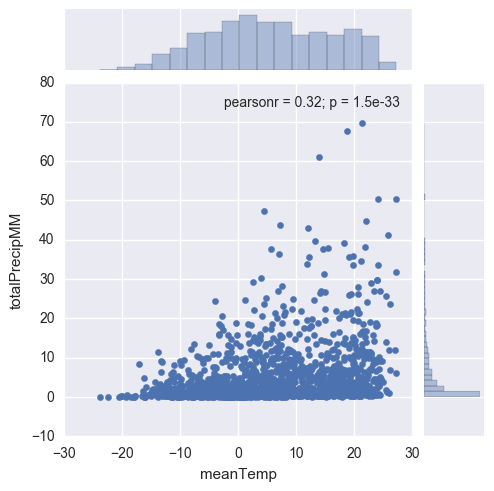

In [24]:
sns.jointplot(
  x="meanTemp", y="totalPrecipMM", data=df[['totalPrecipMM', 'meanTemp']].query('totalPrecipMM != 0'), size=5);

### Joint seasonal distributions

#### Relationship between _winter and summer_ temperatures

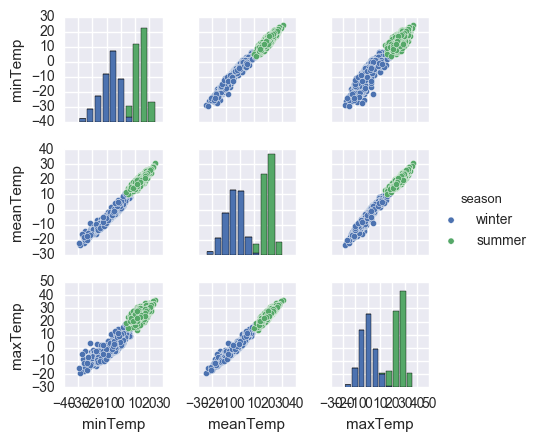

In [15]:
cols = [
#   'month',
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
#   'totalPrecipMM',
#   'totalRainMM'
]
g = sns.pairplot(df.loc[df.season.isin(['winter', 'summer']), cols].fillna(0), hue='season', size=1.5);

There is a clear boundary between temperature values - the values cluster into two normal distributions with minimal overlap

#### Relationship between _fall and winter_ temperatures

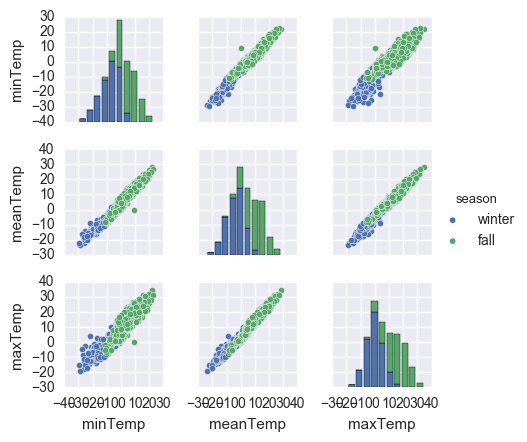

In [16]:
cols = [
#   'month',
  'season',
  'minTemp',
  'meanTemp',
  'maxTemp',
#   'totalPrecipMM',
#   'totalRainMM'
]
g = sns.pairplot(df.loc[df.season.isin(['fall', 'winter']), cols].fillna(0), hue='season', size=1.5);

#### Relationship between **winter and spring** temperatures

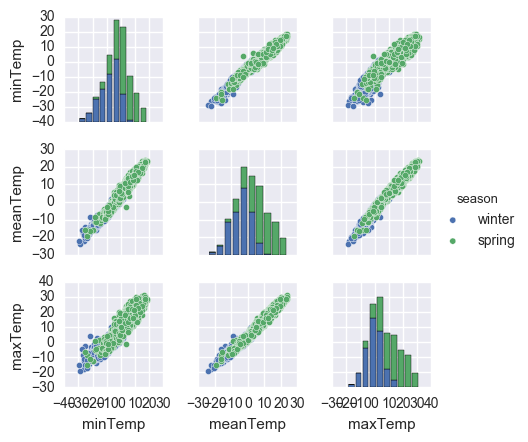

In [17]:
sns.pairplot(df.loc[df.season.isin(['winter', 'spring']), cols].fillna(0), hue='season', size=1.5);

#### Relationship between _spring and summer_ temperatures

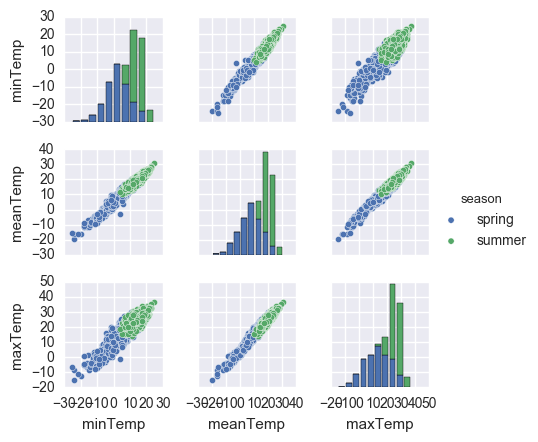

In [18]:
sns.pairplot(df.loc[df.season.isin(['spring', 'summer']), cols].fillna(0), hue='season', size=1.5);

#### Relationship between _spring and fall_ temperatures

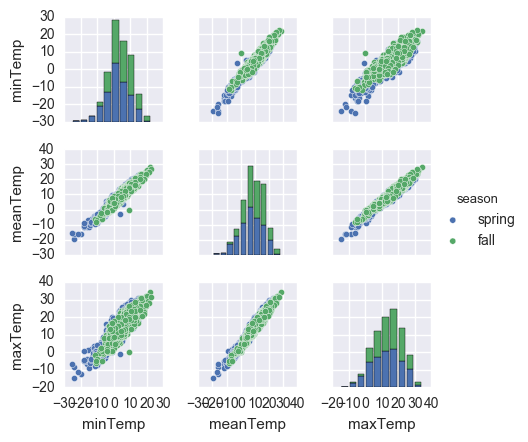

In [19]:
sns.pairplot(df.loc[df.season.isin(['spring', 'fall']), cols].fillna(0), hue='season', size=1.5);

As expected, spring and fall overlap significantly with each other and winter and summer seasons.  What about the rain and precipitation?

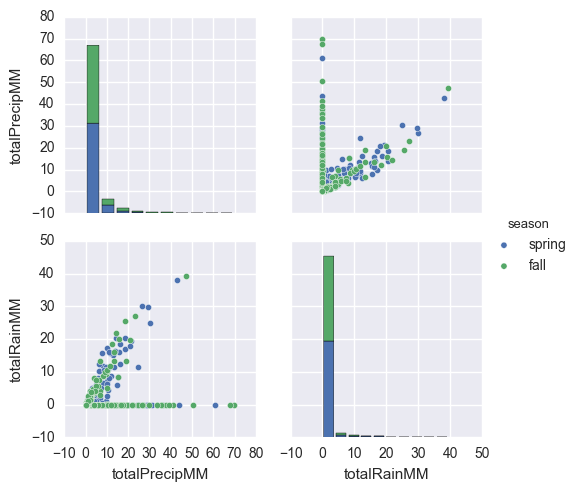

In [20]:
cols = [
#   'month',
  'season',
#   'minTemp',
#   'meanTemp',
#   'maxTemp',
  'totalPrecipMM',
  'totalRainMM'
]
sns.pairplot(df.loc[df.season.isin(['fall', 'spring']), cols].fillna(0), hue='season');

## 2.4 Precipitation Changes Over Time
At this point, we'll only visualize precipitation changes since we are missing significant rainfall data as show above.  In order to more accurately answer the question "has it rained more this year than last", we can use inference to generate rainfall data (i.e. use a predictive model to estimate the rainfall for the missing months).  While we won't further investigate it here (see the next [workbook](#)), it should be noted that inference will be difficult since we've never directly observed the months we are trying to estimate.

The following visualizations describe how precipitation (and thus how rainfall) changes over time.

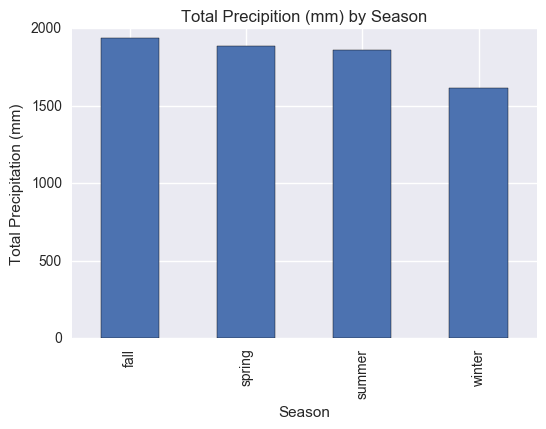

In [21]:
g = df.groupby('season').totalPrecipMM.sum().plot(kind='bar');
g.set_title("Total Precipition (mm) by Season");
g.set_xlabel("Season");
g.set_ylabel("Total Precipitation (mm)");

Total precipitation stays stable accross seasons.  What about accross years?

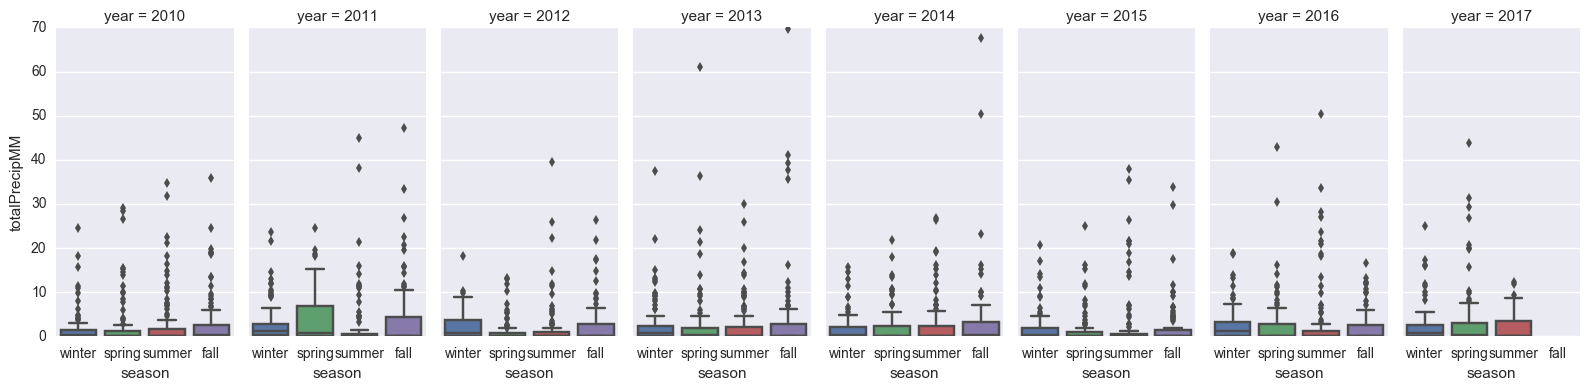

In [22]:
sns.factorplot(x="season", y="totalPrecipMM",
               col="year", data=df, kind="box", size=4, aspect=.5);

It looks like the variation stays roughly constant over time.  We could test this but it's not the focus of this analysis.  We're more interested in changes from 2017 to other years.

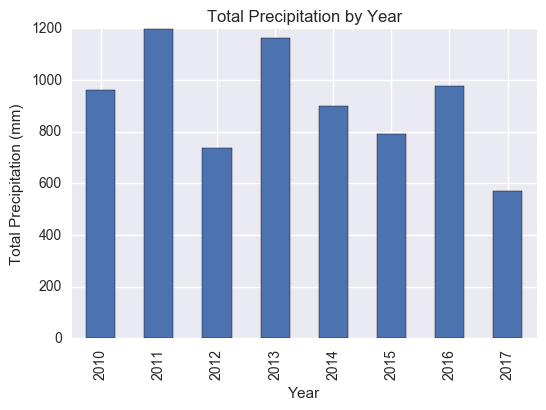

In [23]:
_ = df.groupby('year').totalPrecipMM.sum().plot(kind='bar');
_.set_title("Total Precipitation by Year")
_.set_xlabel("Year");
_.set_ylabel("Total Precipitation (mm)");

We should only consider YTD values since the year isn't done yet

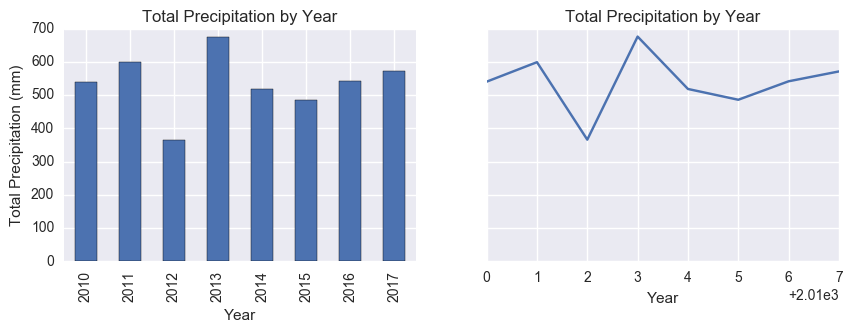

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,3))
month = datetime.now().month
g = df[df.month <= month].groupby('year').totalPrecipMM.sum().plot(kind='bar', ax=ax1);
g.set_title("Total Precipitation by Year")
g.set_xlabel("Year");
g.set_ylabel("Total Precipitation (mm)");

g = df[df.month <= month].groupby('year').totalPrecipMM.sum().plot(kind='line', ax=ax2);
g.set_title("Total Precipitation by Year")
g.set_xlabel("Year");
g.set_ylabel("Total Precipitation (mm)");

We can see that there has been an increase in precipitation over the last three years and so far this year, we've experienced the third highest amount of precipitation since 2010 and have had the most precipitation this year than in the previous three years (2013-2016).  This was also visualized in [Missing rainfall trends](#Missing-rainfall-trends).

#### NOTES
* Normals available at http://climate.weather.gc.ca/climate_normals/results_1981_2010_e.html?stnID=4789&autofwd=1